# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall22/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [ ]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2022-10-26 11:22:35--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2022-10-26 11:22:36 (47.2 MB/s) - ‘cifar.py’ saved [2396/2396]



In [ ]:
import numpy as np
import time
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape, X_test.shape,y_test.shape, X_val.shape, y_val.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,) (10000, 3, 32, 32) (10000,) (10000, 3, 32, 32) (10000,)


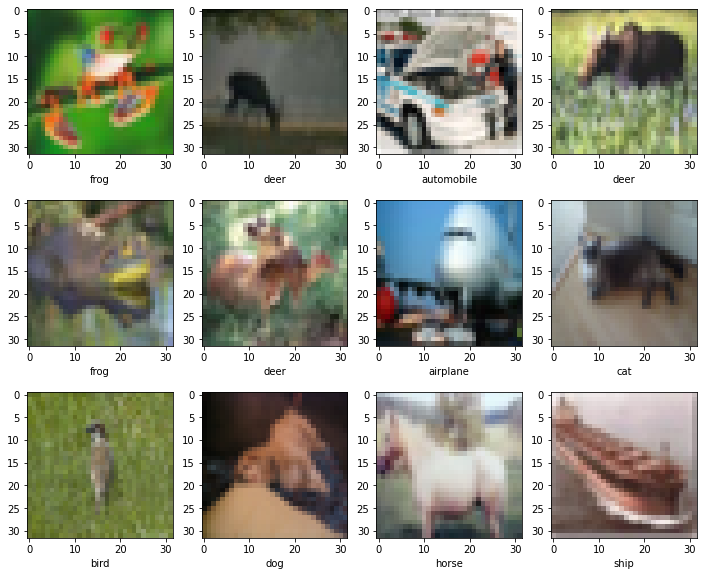

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
!nvidia-smi

Wed Oct 26 11:23:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
x = torch.randn(3, 3).to('cuda')

y = torch.randn(3, 2).to('cuda')

In [ ]:
x @ y

tensor([[-1.3970, -0.8310],
        [ 4.0372, -1.3726],
        [-3.2641, -1.2641]], device='cuda:0')

Let's start with a dense network for our baseline:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)), # [32, 28, 28]
    nn.BatchNorm2d(32),
    nn.MaxPool2d((3, 3)),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=(5, 5)), # [64, 5, 5]
    nn.BatchNorm2d(64),
    nn.ReLU(),

    Flatten(), # [b, c, h, w] -> [b, flat_vector]
    nn.Linear(64 * 5 * 5, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
).to(device)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.4178, device='cuda:0', grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [ ]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 20 # total amount of full passes over training data
batch_size = 100  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(
            X_batch, dtype=torch.float32, device=device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 20 took 2.167s
  training loss (in-iteration): 	1.769535
  validation accuracy: 			42.37 %
Epoch 2 of 20 took 1.419s
  training loss (in-iteration): 	1.353633
  validation accuracy: 			45.14 %
Epoch 3 of 20 took 1.431s
  training loss (in-iteration): 	1.184742
  validation accuracy: 			46.36 %
Epoch 4 of 20 took 1.416s
  training loss (in-iteration): 	1.083338
  validation accuracy: 			50.82 %
Epoch 5 of 20 took 1.420s
  training loss (in-iteration): 	1.006527
  validation accuracy: 			57.81 %
Epoch 6 of 20 took 1.434s
  training loss (in-iteration): 	0.948092
  validation accuracy: 			44.46 %
Epoch 7 of 20 took 1.429s
  training loss (in-iteration): 	0.897730
  validation accuracy: 			65.69 %
Epoch 8 of 20 took 1.421s
  training loss (in-iteration): 	0.855765
  validation accuracy: 			42.59 %
Epoch 9 of 20 took 1.421s
  training loss (in-iteration): 	0.817758
  validation accuracy: 			52.41 %
Epoch 10 of 20 took 1.410s
  training loss (in-iteration): 	0.786199
  validation 

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device = 'cuda'))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		65.38 %
Achievement unlocked: 70lvl Warlock!


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [ ]:
model_1 = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=(5, 5)), # [32, 28, 28]
    nn.BatchNorm2d(128),
    nn.AdaptiveMaxPool2d((5, 5)),
    nn.LeakyReLU(),

    nn.Conv2d(128, 128, kernel_size=(3, 3)), # [64, 5, 5]
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),

    nn.Conv2d(128, 128, kernel_size=(3, 3)), # [64, 5, 5]
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),

    nn.Conv2d(128, 128, kernel_size=(1, 1)), # [64, 5, 5]
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),

    Flatten(), # [b, c, h, w] -> [b, flat_vector]
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),

    nn.Dropout(0.1),

    nn.Linear(128, 10)
).to(device)

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model_1(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
opt = torch.optim.Adam(model_1.parameters(), lr=1e-3)

train_loss = []
val_accuracy = []

In [ ]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model_1.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model_1.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model_1(torch.as_tensor(
            X_batch, dtype=torch.float32, device=device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 4.634s
  training loss (in-iteration): 	1.306100
  validation accuracy: 			59.39 %
Epoch 2 of 100 took 5.078s
  training loss (in-iteration): 	0.958222
  validation accuracy: 			61.17 %
Epoch 3 of 100 took 4.566s
  training loss (in-iteration): 	0.825130
  validation accuracy: 			64.65 %
Epoch 4 of 100 took 4.508s
  training loss (in-iteration): 	0.725551
  validation accuracy: 			69.59 %
Epoch 5 of 100 took 4.541s
  training loss (in-iteration): 	0.663330
  validation accuracy: 			71.59 %
Epoch 6 of 100 took 4.480s
  training loss (in-iteration): 	0.591069
  validation accuracy: 			70.81 %
Epoch 7 of 100 took 4.496s
  training loss (in-iteration): 	0.525198
  validation accuracy: 			72.57 %
Epoch 8 of 100 took 4.542s
  training loss (in-iteration): 	0.477782
  validation accuracy: 			72.39 %
Epoch 9 of 100 took 4.555s
  training loss (in-iteration): 	0.426343
  validation accuracy: 			68.56 %
Epoch 10 of 100 took 4.525s
  training loss (in-iteration): 	0.385504
  v

In [ ]:
model_1.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model_1(torch.as_tensor(X_batch, dtype=torch.float32, device = 'cuda'))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		73.84 %
Achievement unlocked: 80lvl Warlock!


```

```

```

```

```

```

```

```

```

```

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_1 = nn.Sequential()
model_1.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3))
model_1.add_module('batchnorm', nn.BatchNorm2d(10))
model_1.add_module('relu', nn.ReLU())
model_1.add_module('pool1', nn.MaxPool2d(2))
model_1.add_module('flatten', Flatten())

model_1.add_module('lin', nn.Linear(10 * 15 * 15, 100))
model_1.add_module('batchnorm2', nn.BatchNorm1d(100))
model_1.add_module('l_relu', nn.ReLU())
model_1.add_module('dropout', nn.Dropout(0.1))
model_1.add_module('output', nn.Linear(100, 10))

model_1.to(device)

Sequential(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (lin): Linear(in_features=2250, out_features=100, bias=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=100, out_features=10, bias=True)
)


```

```

```

```

```

```

```

```

```

```

```

```

```

```
## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [ ]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment,)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


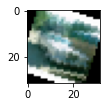

In [ ]:

for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
        break
    break

    #raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_1 = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=(5, 5)), # [32, 28, 28]
    nn.BatchNorm2d(128),
    nn.AdaptiveMaxPool2d((5, 5)),
    nn.LeakyReLU(),

    nn.Conv2d(128, 128, kernel_size=(3, 3)), # [64, 5, 5]
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),

    nn.Conv2d(128, 128, kernel_size=(3, 3)), # [64, 5, 5]
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),

    nn.Conv2d(128, 128, kernel_size=(1, 1)), # [64, 5, 5]
    nn.BatchNorm2d(128),
    nn.LeakyReLU(),

    Flatten(), # [b, c, h, w] -> [b, flat_vector]
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),

    nn.Dropout(0.1),

    nn.Linear(128, 10)
).to(device)

In [ ]:
opt = torch.optim.Adam(model_1.parameters(), lr=1e-3)

train_loss = []
val_accuracy = []

num_epochs = 100 # total amount of full passes over training data
batch_size = 32

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model_1.train(True) # enable dropout / batch_norm training behavior
    for (x_batch, y_batch) in train_batch_gen:
        #print(len(x_batch))
        # train on batch
        loss = compute_loss(x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(train_loader) // batch_size :])))

Epoch 1 of 100 took 32.617s
  training loss (in-iteration): 	1.585883
Epoch 2 of 100 took 33.147s
  training loss (in-iteration): 	1.353747
Epoch 3 of 100 took 31.459s
  training loss (in-iteration): 	1.250873
Epoch 4 of 100 took 31.606s
  training loss (in-iteration): 	1.187804
Epoch 5 of 100 took 31.836s
  training loss (in-iteration): 	1.131894
Epoch 6 of 100 took 31.647s
  training loss (in-iteration): 	1.103652
Epoch 7 of 100 took 33.959s
  training loss (in-iteration): 	1.071120
Epoch 8 of 100 took 31.759s
  training loss (in-iteration): 	1.036625
Epoch 9 of 100 took 31.875s
  training loss (in-iteration): 	1.017814
Epoch 10 of 100 took 31.822s
  training loss (in-iteration): 	0.996057
Epoch 11 of 100 took 31.556s
  training loss (in-iteration): 	0.977058
Epoch 12 of 100 took 31.785s
  training loss (in-iteration): 	0.962627
Epoch 13 of 100 took 32.008s
  training loss (in-iteration): 	0.950253
Epoch 14 of 100 took 31.691s
  training loss (in-iteration): 	0.932386
Epoch 15 of 100

When testing, we don't need random crops, just normalize with same statistics.

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test,)
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)


model_1.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for (x_batch, y_batch) in test_batch_gen:
    logits = model_1(torch.as_tensor(x_batch, dtype=torch.float32, device = 'cuda'))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		80.11 %
Achievement unlocked: 110lvl Warlock!


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import random_split

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment,)

### split train and valid data
valid_size, train_size = 10000, len(train_loader) - 10000
train_loader, valid_loader = random_split(train_loader, [train_size, valid_size])
print(f'Size train and valid: {len(train_loader)}, {len(valid_loader)}')


train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)
print(f'Size test: {len(test_loader)}')
# for test
test_batch_gen = torch.utils.data.DataLoader(test_loader,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=1)
# for valid
val_batch_gen = torch.utils.data.DataLoader(valid_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

Size train and valid: 40000, 10000
Size test: 10000


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#device = 'cpu'

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('batchnorm', nn.BatchNorm2d(32))
model.add_module('relu', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('batchnorm2', nn.BatchNorm2d(64))
model.add_module('relu2', nn.ReLU())
model.add_module('pool12', nn.MaxPool2d(2))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('batchnorm3', nn.BatchNorm2d(128))
model.add_module('relu3', nn.ReLU())
model.add_module('pool13', nn.MaxPool2d(2))

model.add_module('flatten', Flatten())
model.add_module('lin', nn.Linear(128 * 4 * 4, 512))
model.add_module('batchnorm4', nn.BatchNorm1d(512))
model.add_module('l_relu', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('output', nn.Linear(512, 10))

model.to(device)

cuda


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (lin): Linear(in_features=2048, out_features=512, bias=True)
  (batchnorm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32, device=device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64, device=device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [ ]:
%%time
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

val_loss = []
train_loss = []
val_accuracy = []
train_accuracy = []
x_train_loss, x_val_loss, x_train_accuracy, x_val_accuracy = [], [], [], []

num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for (x_batch, y_batch) in train_batch_gen:
        # train on batch
        loss = compute_loss(x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

        logits_train = model(torch.as_tensor(x_batch, dtype=torch.float32, device=device))
        y_pred = logits_train.max(1)[1].cpu().data.numpy()
        train_accuracy.append(np.mean(y_batch.numpy() == y_pred))

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for (x_batch, y_batch) in val_batch_gen:
        logits = model(torch.as_tensor(
            x_batch, dtype=torch.float32, device=device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        model_loss = compute_loss(x_batch, y_batch)
        val_loss.append(model_loss.cpu().data.numpy())
        val_accuracy.append(np.mean(y_batch.numpy() == y_pred))


    # Then we print the results for this epoch:
    curr_train_loss = np.mean(train_loss[-len(train_loader) // batch_size :])
    curr_val_loss = np.mean(val_loss[-len(valid_loader) // batch_size :])
    curr_train_accuracy = np.mean(train_accuracy[-len(train_loader) // batch_size :]) * 100
    curr_val_accuracy = np.mean(val_accuracy[-len(valid_loader) // batch_size :]) * 100

    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(curr_train_loss))
    print("  validation loss (in-iteration): \t{:.6f}".format(curr_val_loss))
    print("  validation accuracy: \t\t\t{:.2f} %".format(curr_val_accuracy))
    x_train_loss.append(curr_train_loss)
    x_val_loss.append(curr_val_loss)
    x_train_accuracy.append(curr_train_accuracy)
    x_val_accuracy.append(curr_val_accuracy)

Epoch 1 of 100 took 29.984s
  training loss (in-iteration): 	1.508022
  validation loss (in-iteration): 	1.292268
  validation accuracy: 			53.40 %
Epoch 2 of 100 took 29.813s
  training loss (in-iteration): 	1.251375
  validation loss (in-iteration): 	1.140868
  validation accuracy: 			58.79 %
Epoch 3 of 100 took 29.753s
  training loss (in-iteration): 	1.137193
  validation loss (in-iteration): 	1.025848
  validation accuracy: 			63.16 %
Epoch 4 of 100 took 29.994s
  training loss (in-iteration): 	1.074873
  validation loss (in-iteration): 	0.953296
  validation accuracy: 			66.33 %
Epoch 5 of 100 took 30.020s
  training loss (in-iteration): 	1.011982
  validation loss (in-iteration): 	0.944471
  validation accuracy: 			66.46 %
Epoch 6 of 100 took 29.961s
  training loss (in-iteration): 	0.972717
  validation loss (in-iteration): 	0.911151
  validation accuracy: 			66.69 %
Epoch 7 of 100 took 29.696s
  training loss (in-iteration): 	0.937362
  validation loss (in-iteration): 	0.88031

In [ ]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for (x_batch, y_batch) in test_batch_gen:
    logits = model(torch.as_tensor(x_batch, dtype=torch.float32, device = 'cuda')) # device
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch.numpy() == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		84.70 %
Achievement unlocked: 110lvl Warlock!


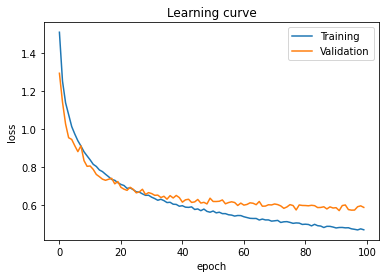

In [ ]:
#print(f'len: {x_train_loss}, {x_val_loss}')
plt.plot(x_train_loss, label='training loss')
plt.plot(x_val_loss, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Learning curve');

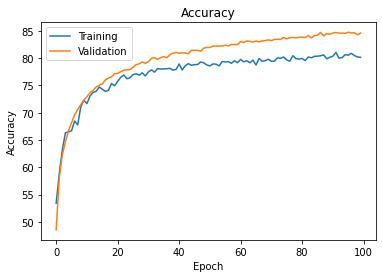

In [ ]:
plt.plot(x_val_accuracy, label='accuracy on validation')
plt.plot(x_train_accuracy, label='accuracy on training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'])

**Report**

You can see on the plot "Accuracy" model reaches an accuracy around 84% on validation. Also valid accuracy higher than train, it may be happened cause we using Droupout, on validation all features are used.  
If you see at the plot "Lerning curve" traning and val losses decrease over time, however starting from the 80th epoch, the loss does not change, so not overfitting in this case.

Finally, model reach 84.70 % accuracy on test.



---



In [ ]:
# X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(40000, 3, 32, 32) (40000,) (10000, 3, 32, 32) (10000,) (10000, 3, 32, 32) (10000,)


In [ ]:
# # An auxilary function that returns mini-batches for neural network training
# def iterate_minibatches(X, y, batchsize):
#     indices = np.random.permutation(np.arange(len(X)))
#     for start in range(0, len(indices), batchsize):
#         ix = indices[start: start + batchsize]
#         yield X[ix], y[ix]

In [ ]:
# class PrintSize(nn.Module):
#   def init(self):
#     super(PrintSize, self).init()

#   def forward(self, x):
#     print(x.shape)
#     return x

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)
# #device = 'cpu'

# model = nn.Sequential()
# model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
# model.add_module('batchnorm', nn.BatchNorm2d(32))
# model.add_module('relu', nn.ReLU())
# model.add_module('pool1', nn.MaxPool2d(2))

# model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
# model.add_module('batchnorm2', nn.BatchNorm2d(64))
# model.add_module('relu2', nn.ReLU())
# model.add_module('pool12', nn.MaxPool2d(2))

# model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
# model.add_module('batchnorm3', nn.BatchNorm2d(128))
# model.add_module('relu3', nn.ReLU())
# model.add_module('pool13', nn.MaxPool2d(2))

# #model.add_module('print1', PrintSize())
# model.add_module('flatten', Flatten())
# #model.add_module('print2', PrintSize())
# model.add_module('lin', nn.Linear(128 * 4 * 4, 512))
# model.add_module('batchnorm4', nn.BatchNorm1d(512))
# model.add_module('l_relu', nn.ReLU())
# model.add_module('dropout', nn.Dropout(0.3)) # check this case



# # model.add_module('lin2', nn.Linear(128 * 2 * 2, 512)) #128 2 2
# # model.add_module('l_relu2', nn.ReLU())
# # model.add_module('dropout2', nn.Dropout(0.1))

# model.add_module('output', nn.Linear(512, 10))

# model.to(device)

cuda


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (lin): Linear(in_features=2048, out_features=512, bias=True)
  (batchnorm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# train_loss = []
# val_accuracy = []

# num_epochs = 100
# batch_size = 50

# for epoch in range(num_epochs):
#     # In each epoch, we do a full pass over the training data:
#     start_time = time.time()
#     model.train(True) # enable dropout / batch_norm training behavior
#     for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
#         # train on batch
#         loss = compute_loss(X_batch, y_batch)
#         loss.backward()
#         opt.step()
#         opt.zero_grad()
#         train_loss.append(loss.cpu().data.numpy())

#     # And a full pass over the validation data:
#     model.train(False) # disable dropout / use averages for batch_norm
#     for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
#         logits = model(torch.as_tensor(
#             X_batch, dtype=torch.float32, device=device))
#         y_pred = logits.max(1)[1].cpu().data.numpy()
#         val_accuracy.append(np.mean(y_batch == y_pred))


#     # Then we print the results for this epoch:
#     print("Epoch {} of {} took {:.3f}s".format(
#         epoch + 1, num_epochs, time.time() - start_time))
#     print("  training loss (in-iteration): \t{:.6f}".format(
#         np.mean(train_loss[-len(X_train) // batch_size :])))
#     print("  validation accuracy: \t\t\t{:.2f} %".format(
#         np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 4.130s
  training loss (in-iteration): 	1.156131
  validation accuracy: 			67.02 %
Epoch 2 of 100 took 4.084s
  training loss (in-iteration): 	0.825373
  validation accuracy: 			72.51 %
Epoch 3 of 100 took 4.092s
  training loss (in-iteration): 	0.685952
  validation accuracy: 			70.19 %
Epoch 4 of 100 took 4.077s
  training loss (in-iteration): 	0.586901
  validation accuracy: 			75.26 %
Epoch 5 of 100 took 4.162s
  training loss (in-iteration): 	0.489599
  validation accuracy: 			75.66 %
Epoch 6 of 100 took 4.049s
  training loss (in-iteration): 	0.413365
  validation accuracy: 			71.97 %
Epoch 7 of 100 took 4.097s
  training loss (in-iteration): 	0.343528
  validation accuracy: 			75.53 %
Epoch 8 of 100 took 4.117s
  training loss (in-iteration): 	0.281125
  validation accuracy: 			72.67 %
Epoch 9 of 100 took 4.057s
  training loss (in-iteration): 	0.240487
  validation accuracy: 			75.31 %
Epoch 10 of 100 took 4.759s
  training loss (in-iteration): 	0.209911
  v

In [ ]:
# model.train(False) # disable dropout / use averages for batch_norm
# test_batch_acc = []
# for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
#     logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device = 'cuda'))
#     y_pred = logits.max(1)[1].cpu().data.numpy()
#     test_batch_acc.append(np.mean(y_batch == y_pred))

# test_accuracy = np.mean(test_batch_acc)

# print("Final results:")
# print("  test accuracy:\t\t{:.2f} %".format(
#     test_accuracy * 100))

# if test_accuracy * 100 > 95:
#     print("Double-check, than consider applying for NIPS'17. SRSly.")
# elif test_accuracy * 100 > 90:
#     print("U'r freakin' amazin'!")
# elif test_accuracy * 100 > 80:
#     print("Achievement unlocked: 110lvl Warlock!")
# elif test_accuracy * 100 > 70:
#     print("Achievement unlocked: 80lvl Warlock!")
# elif test_accuracy * 100 > 60:
#     print("Achievement unlocked: 70lvl Warlock!")
# elif test_accuracy * 100 > 50:
#     print("Achievement unlocked: 60lvl Warlock!")
# else:
#     print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		78.52 %
Achievement unlocked: 80lvl Warlock!


In [ ]:
# model.train(False) # disable dropout / use averages for batch_norm
# test_batch_acc = []
# for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
#     logits = model(torch.as_tensor(X_batch, dtype=torch.float32, device = 'cuda'))
#     y_pred = logits.max(1)[1].cpu().data.numpy()
#     test_batch_acc.append(np.mean(y_batch == y_pred))

# test_accuracy = np.mean(test_batch_acc)

# print("Final results:")
# print("  test accuracy:\t\t{:.2f} %".format(
#     test_accuracy * 100))

# if test_accuracy * 100 > 95:
#     print("Double-check, than consider applying for NIPS'17. SRSly.")
# elif test_accuracy * 100 > 90:
#     print("U'r freakin' amazin'!")
# elif test_accuracy * 100 > 80:
#     print("Achievement unlocked: 110lvl Warlock!")
# elif test_accuracy * 100 > 70:
#     print("Achievement unlocked: 80lvl Warlock!")
# elif test_accuracy * 100 > 60:
#     print("Achievement unlocked: 70lvl Warlock!")
# elif test_accuracy * 100 > 50:
#     print("Achievement unlocked: 60lvl Warlock!")
# else:
#     print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		78.07 %
Achievement unlocked: 80lvl Warlock!
